# Исследование и запуск виртуальных сред и обучение модели SmolVLM на данных из этих сред

## Load Libs

In [1]:
import torch
from PIL import Image
from transformers.image_utils import load_image
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics3ForConditionalGeneration, AutoModelForVision2Seq, TrainingArguments, Trainer
import json
import os
import pickle
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import wandb
from datasets import load_dataset

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import gc

/home/anton/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Checking the zero-shot capabilities of the SmolVLM

### Сбор датасета
Сначала нам нужно запустить скрипт *** из RL4VLA чтобы получить PutOnPlateIn.../75, далее выполняем следующие блоки кода

In [12]:
def load_data_from_npz(path = None, num_of_samples = None):
    '''Parce episode data files, extract only first, mid and end data'''
    if path is None:
        raise ValueError("You're not send path")
    
    npz_files = [f for f in os.listdir(path) if f.find('.npz') != -1]

    if num_of_samples != None:
        npz_files = npz_files[0:num_of_samples]

    files = {}
    
    for file in npz_files:
        file_path = path + "/" + file
        
        with np.load(file_path, allow_pickle=True) as data:
            mid_index = int(len(data["arr_0"].item()["info"])/2)

            file_summary = {
                "first_iter": {"data": data["arr_0"].item()["info"][0], "image": data["arr_0"].item()["image"][0]},
                "mid_iter": {"data": data["arr_0"].item()["info"][mid_index], "image": data["arr_0"].item()["image"][mid_index]},
                "last_iter": {"data": data["arr_0"].item()["info"][-1], "image": data["arr_0"].item()["image"][-1]},
                "first_iter_QA": {},
                "mid_iter_QA": {},
                "last_iter_QA": {},
            }

            files[f"{file}"] = file_summary

    return files


def load_data_from_npz_general(path = None, num_of_samples = None, filename = False):
    '''Parce every frame in collected episodes'''
    if path is None:
        raise ValueError("You're not send path")
    
    if filename:
        npz_files = [f for f in os.listdir(path) if f.find(filename) != -1]
    else:
        npz_files = [f for f in os.listdir(path) if f.find('.npz') != -1]

    if num_of_samples != None:
        npz_files = npz_files[0:num_of_samples]

    files = {}
    
    for file in npz_files:
        file_path = path + "/" + file
        file_summary = {}

        with np.load(file_path, allow_pickle=True) as data:
            for i in range(len(data["arr_0"].item()["info"])):
                file_summary[f"{i}_frame"] = {
                    "data": data["arr_0"].item()["info"][i], 
                    "image": data["arr_0"].item()["image"][i], 
                    f"QA": {},
                    }

            files[f"{file}"] = file_summary

    return files

In [ ]:
carrot_on_plate_files = load_data_from_npz("./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/75/data", num_of_samples=20)
spoon_on_table_clothin_files = load_data_from_npz("./RL4VLA/ManiSkill/mp_collect/PutSpoonOnTableClothInScene-v1/75/data", num_of_samples=10)

In [3]:
# carrot_on_plate_file_one_episode = load_data_from_npz_general("./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/75/data", num_of_samples=1)
spoon_on_table_file_one_episode = load_data_from_npz_general("./RL4VLA/ManiSkill/mp_collect/PutSpoonOnTableClothInScene-v1/75/data", filename = "success_proc_0_numid_19_epsid_20.npz")

{'elapsed_steps': array([34], dtype=int32), 'moved_correct_obj': array([False]), 'moved_wrong_obj': array([False]), 'is_src_obj_grasped': array([ True]), 'consecutive_grasp': array([ True]), 'src_on_target': array([ True]), 'success': array([ True])}


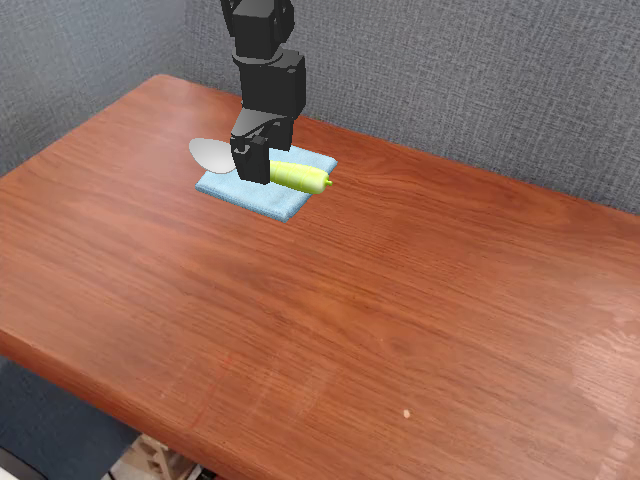

In [9]:
n = 33

print(spoon_on_table_file_one_episode["success_proc_0_numid_19_epsid_20.npz"][f"{n}_frame"]["data"])
spoon_on_table_file_one_episode["success_proc_0_numid_19_epsid_20.npz"][f"{n}_frame"]["image"]

In [22]:
print(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{n}_frame"]["QA"])

{}


### Проверим zero-shot способности нашей модели на собранных данных
Для этого нам сначала нужно её загрузить, потом на собранном датасете записать ответы, позже оценить качество с помощью confusion matrix

In [15]:
torch.cuda.empty_cache()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 12427.57it/s]


In [11]:
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager", 
).to(DEVICE)

/home/anton/miniconda3/lib/python3.13/site-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


In [16]:
questions_list = [
    "What objects are in the scene?",
    "Where is objects relative to each other?", #"Where is the carrot relative to the plate?",
    "Is the carrot on the plate?",
    "Is the gripper holding an object?",
    "Is there an object that can be eaten?",
]


def collect_answers(data, questions_list, model, processor):
    '''Collect answers for the every question in the question_list and group it by filename'''

    data_len = len(data) 

    collecting_data_loop = tqdm(enumerate(data.items()), leave=True)
    
    iters = [
        "first_iter",
        "mid_iter",
        "last_iter"
    ]

    for i, (filename, filename_data) in collecting_data_loop:
        # Prepare inputs

        for question in questions_list:
            
            message = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
            ]


            prompt = processor.apply_chat_template(message, add_generation_prompt=True)
            for Iter in iters:
                inputs = processor(text=prompt, images=[filename_data[Iter]["image"]], return_tensors="pt")
                inputs = inputs.to(DEVICE)

                # Generate outputs
                generated_ids = model.generate(**inputs, max_new_tokens=500)
                generated_text = processor.batch_decode(
                    generated_ids,
                    skip_special_tokens=True,
                )

                answer = generated_text[0].split("Assistant: ")[-1]

                filename_data[Iter + "_QA"][question] = answer
                
                
            collecting_data_loop.set_description(f"collecting data from {i+1}/{data_len} file: {filename}")


def collect_answers_general(data, questions_list, model, processor):
    '''Collect answers for the every question in the question_list and group it by filename'''

    data_len = len(data) 

    collecting_data_loop = tqdm(enumerate(data.items()), leave=True)

    for j, (filename, filename_data) in collecting_data_loop:
        # Prepare inputs

        for question in questions_list:
            
            message = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
            ]
               
            prompt = processor.apply_chat_template(message, add_generation_prompt=True)
            for i in range(len(filename_data)):
                inputs = processor(text=prompt, images=[filename_data[f"{i}_frame"]["image"]], return_tensors="pt")
                inputs = inputs.to(DEVICE)

                # Generate outputs
                generated_ids = model.generate(**inputs, max_new_tokens=500)
                generated_text = processor.batch_decode(
                    generated_ids,
                    skip_special_tokens=True,
                )

                answer = generated_text[0].split("Assistant: ")[-1]

                filename_data[f"{i}_frame"]["QA"][question] = answer
                
                
            collecting_data_loop.set_description(f"collecting data from {j+1}/{data_len} file: {filename}")

In [12]:
questions_list = [
    "What objects are in the scene?",
    "Where is objects relative to each other?", 
    "Is the carrot on the plate?",
    "Is the gripper holding an object?",
    "Is there an object that can be eaten?",
    "Is the carrot on the plate? Yes/No.",
    "Is the orange object (carrot) on the yellow plate in this image? Yes/No.",
    "Is the orange object on the yellow object in this image? Yes/No.", 
]

collect_answers(carrot_on_plate_files, questions_list, model=model, processor=processor)

with open('carrot_on_plate_FML.pkl', 'wb') as f: #First Mid Last
    pickle.dump(carrot_on_plate_files, f)

collect_answers_general(carrot_on_plate_file_one_episode, questions_list, model=model, processor=processor)

with open('carrot_on_plate_one_episode.pkl', 'wb') as f: 
    pickle.dump(carrot_on_plate_file_one_episode, f)

questions_list = [
    "What objects are in the scene?",
    "Where is objects relative to each other?", 
    "Is the spoon on the clothin? Yes/No.",
    "Is the gripper holding an object?",
    "Is there an object that can be eaten?",
    "Is the green/yellow object (spoon) on the blue clothin in this image? Yes/No.",
    "Is the green/yellow object on the blue object in this image? Yes/No.",
]

collect_answers(spoon_on_table_clothin_files, questions_list, model=model, processor=processor)

with open('spoon_on_table_clothin_files_FML.pkl', 'wb') as f: 
    pickle.dump(spoon_on_table_clothin_files, f)

collect_answers_general(spoon_on_table_file_one_episode, questions_list, model=model, processor=processor)

with open('spoon_on_table_file_one_episode.pkl', 'wb') as f: 
    pickle.dump(spoon_on_table_file_one_episode, f)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [25:13, 75.66s/it]
collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [14:22, 862.20s/it]
collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [10:59, 65.98s/it]
collecting data from 1/1 file: success_proc_0_numid_19_epsid_20.npz: : 1it [12:26, 746.40s/it]


In [3]:
# Загрузим существующие данные
with open('carrot_on_plate_FML.pkl', 'rb') as f: #First Mid Last
    carrot_on_plate_files = pickle.load(f)

with open('carrot_on_plate_one_episode.pkl', 'rb') as f: 
    carrot_on_plate_file_one_episode = pickle.load(f)

with open('spoon_on_table_file_one_episode.pkl', 'rb') as f: 
    spoon_on_table_file_one_episode = pickle.load(f)

# with open('spoon_on_table_clothin_files_FML.pkl', 'rb') as f: 
#     spoon_on_table_clothin_files = pickle.load(f)

### Посчитаем метрики
Зная GT ответы от среды (И тот факт, что success в начале говорит о том, что последний эпизод содержит в себе морковь на тарелке) 
/!!!*REFACTOR CODE/ - вычисляем confusion matrix, оценивая качество работы исходной модели

Посмотрим сначала на общие вопросы и оценим, насколько модель может в пространственное понимание

In [47]:
counter = 0
carrot_counter = 0
for _, item in carrot_on_plate_files.items():
    counter+=2
    print(item["last_iter_QA"]["Is there an object that can be eaten?"])
    if item["last_iter_QA"]["Is there an object that can be eaten?"].find("carrot") != -1:
        carrot_counter+=1
    print(item["first_iter_QA"]["Is there an object that can be eaten?"])
    if item["first_iter_QA"]["Is there an object that can be eaten?"].find("carrot") != -1:
        carrot_counter+=1

Yes, there is a food item on the table.
Yes, there is a carrot on the plate.
Yes, there is a carrot on the table.
Yes, there is a carrot and a green vegetable on the table.
Yes, there is a carrot in the image.
Yes, there is a carrot in the image.
Yes, there is a fruit in the image.
Yes, there is a carrot in the image.
Yes, there is a food item on the table.
Yes, there is a carrot and a green vegetable on the table.
Yes, there is a carrot and an orange on the table.
Yes, there is a carrot on the table.
Yes, there is a carrot on the table.
Yes, there is a carrot and a vegetable in the image.
Yes, there is a carrot on the table.
Yes, there is a carrot on the table.
Yes, there is a food item in the image.
Yes, there is a carrot on the table.
Yes, there is a fruit on the table.
Yes, there is a carrot in the image.
Yes, there is a carrot on the table.
Yes, there is a carrot and a green vegetable on the table.
Yes, there is an orange in the image.
Yes, there is a carrot on the table.
Yes, the

Можно видеть, что модель понимает, что на изображении есть съедобный объект, но она не всегда распознаёт объект как морковь. Также иногда модель воспринимает листья моркови как отдельный съедобный объект

In [48]:
print(float(carrot_counter/counter))

0.75


['Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding'] ['Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding']


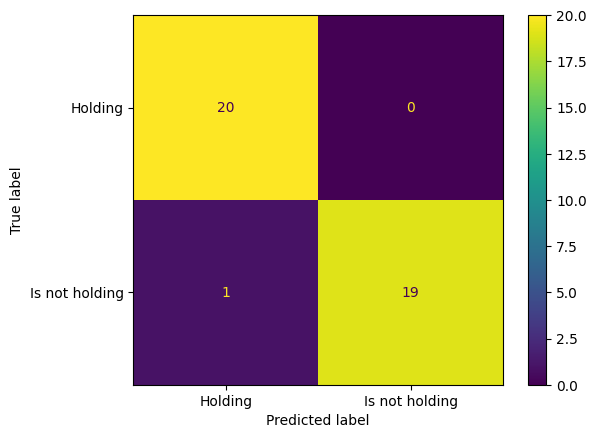

In [45]:
Hold_carrot = ["Holding"]*20
Is_not_hold_carrot = ["Is not holding"]*20
targets = Hold_carrot + Is_not_hold_carrot

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("Holding" if item["last_iter_QA"]["Is the gripper holding an object?"].lower().find("yes") != -1 else "Is not holding")
    preds_not_on_the_plate.append("Holding" if item["first_iter_QA"]["Is the gripper holding an object?"].lower().find("yes") != -1 else "Is not holding")

print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["Holding", "Is not holding"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Holding", "Is not holding"])

disp.plot()

#### Question - Carrot on plate

['carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate'] ['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate']


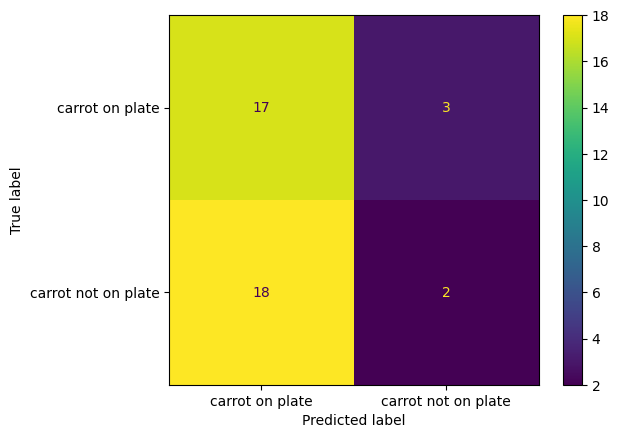

In [14]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()
# print(preds)
# print(targets)
    

Такие результаты могут быть получены в следствии неправильной формулировки вопроса
Посмотрим, изменится ли качество если добавить yes/no

In [ ]:
question = ["Is the carrot on the plate? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

0it [00:00, ?it/s]

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [03:26, 10.31s/it]


['carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate'] ['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate']


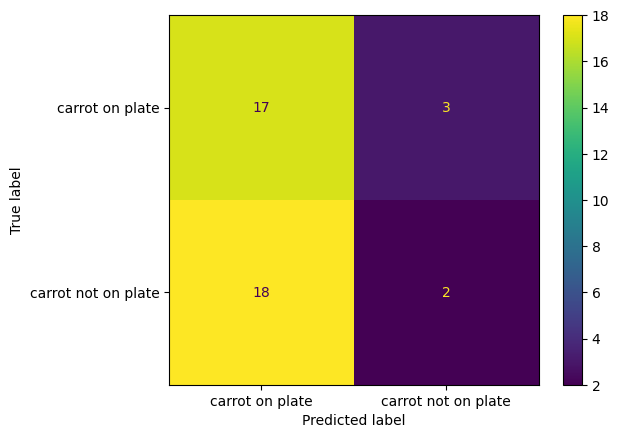

In [15]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the carrot on the plate? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the carrot on the plate? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

Качество осталось абсолютно таким же. Значит в предобученной модели нет разницы, ставим мы yes/no в конце или нет

In [ ]:
question = ["Is the orange object (carrot) on the yellow plate in this image? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [02:35,  7.80s/it]


['carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate'] ['carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate']


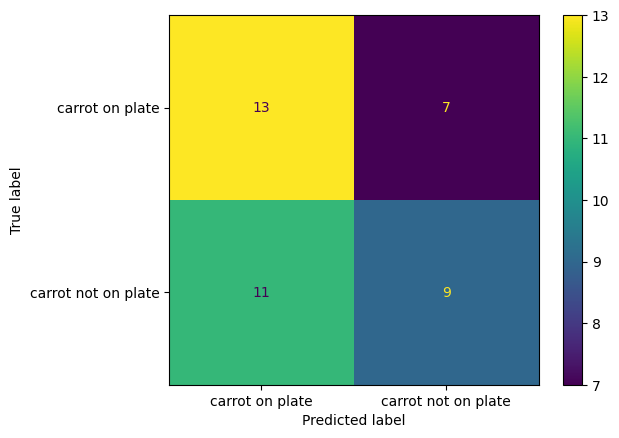

In [ ]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the orange object (carrot) on the yellow plate in this image? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the orange object (carrot) on the yellow plate in this image? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

Показатели улучшились. Есть подозрение, что для исходной VLM намного больше значит цветовое представление объекта, чем общее название

In [16]:
question = ["Is the orange object on the yellow object in this image? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [02:34,  7.73s/it]


['carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate']


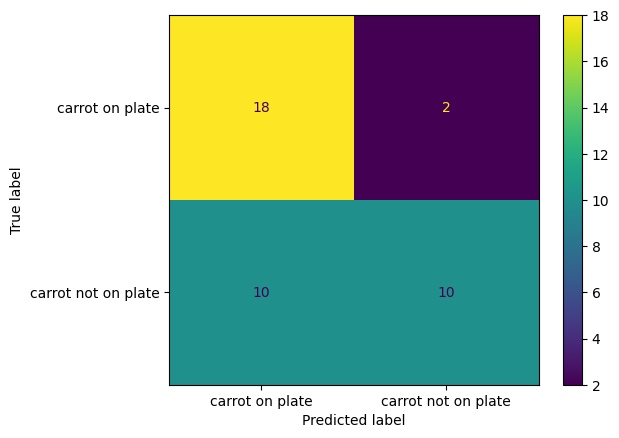

In [ ]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the orange object on the yellow object in this image? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the orange object on the yellow object in this image? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")

print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

Делаем вывод, что для предобученной модели целесообразнее спрашивать о взаимоотношении объектов на основании их цвета, а не "объектного значения"

##### Также посмотрим, как модель себя покажет в рамках одного эпизода

In [30]:
question = ["Is the carrot on the plate?"]

collect_answers_general(carrot_on_plate_file_one_episode, question, model=model, processor=processor)

collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [01:46, 106.10s/it]


['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on pla

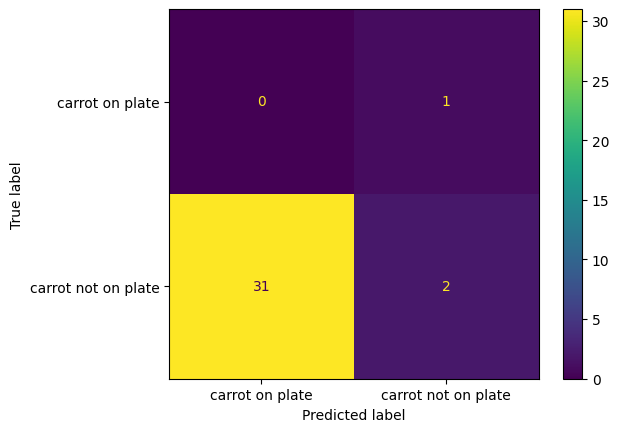

In [32]:
targets = []
preds = []


for _, item in carrot_on_plate_file_one_episode.items():
    for i in range(len(item)):
        preds.append("carrot on plate" if item[f"{i}_frame"]["QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
        targets.append("carrot on plate" if item[f"{i}_frame"]["data"]["src_on_target"] else "carrot not on plate")
print(preds, targets)

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

Попробуем улучшить понимание модели, что именно объект "морковь" лежит или не лежит именно на объекте "тарелка"

### Question - spoon on clothin

In [50]:
question = ["Is the spoon on the clothin? Yes/No."]

collect_answers(spoon_on_table_clothin_files, question, model=model, processor=processor)

collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [01:18,  7.89s/it]


['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


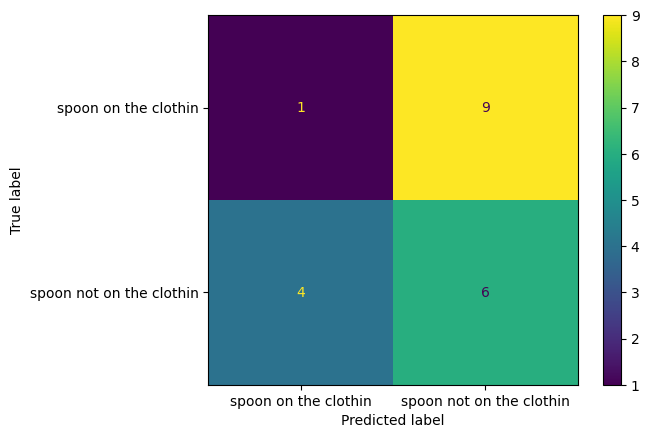

In [51]:
spoon_on_the_plate = ["spoon on the clothin"]*10
spoon_not_on_the_plate = ["spoon not on the clothin"]*10
targets = spoon_on_the_plate + spoon_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in spoon_on_table_clothin_files.items():
    preds_on_the_plate.append("spoon on the clothin" if item["last_iter_QA"]["Is the spoon on the clothin? Yes/No."].lower().find("yes") != -1 else "spoon not on the clothin")
    preds_not_on_the_plate.append("spoon on the clothin" if item["first_iter_QA"]["Is the spoon on the clothin? Yes/No."].lower().find("yes") != -1 else "spoon not on the clothin")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["spoon on the clothin", "spoon not on the clothin"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoon on the clothin", "spoon not on the clothin"])

disp.plot()

In [43]:
question = ["Is the green/yellow object (spoon) on the blue clothin in this image? Yes/No."]

collect_answers(spoon_on_table_clothin_files, question, model=model, processor=processor)

collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [01:27,  8.74s/it]


['spoon not on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


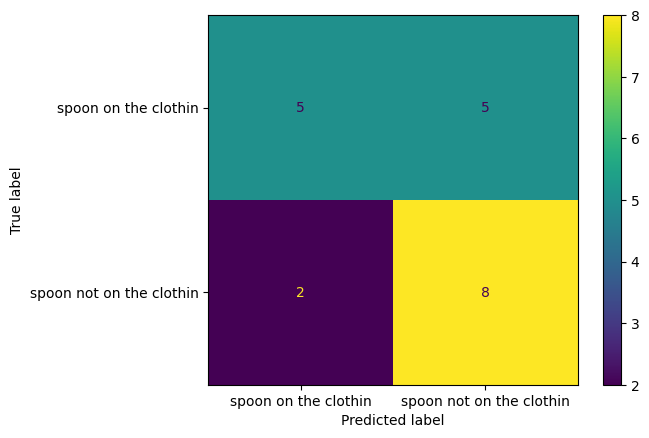

In [44]:
spoon_on_the_plate = ["spoon on the clothin"]*10
spoon_not_on_the_plate = ["spoon not on the clothin"]*10
targets = spoon_on_the_plate + spoon_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in spoon_on_table_clothin_files.items():
    preds_on_the_plate.append("spoon on the clothin" if item["last_iter_QA"]["Is the green/yellow object (spoon) on the blue clothin in this image? Yes/No."].lower().find("yes") != -1 else "spoon not on the clothin")
    preds_not_on_the_plate.append("spoon on the clothin" if item["first_iter_QA"]["Is the green/yellow object (spoon) on the blue clothin in this image? Yes/No."].lower().find("yes") != -1 else "spoon not on the clothin")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["spoon on the clothin", "spoon not on the clothin"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoon on the clothin", "spoon not on the clothin"])

disp.plot()

In [41]:
question = ["Is the green/yellow object on the blue object in this image? Yes/No."]

collect_answers(spoon_on_table_clothin_files, question, model=model, processor=processor)

collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [01:25,  8.57s/it]


['spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


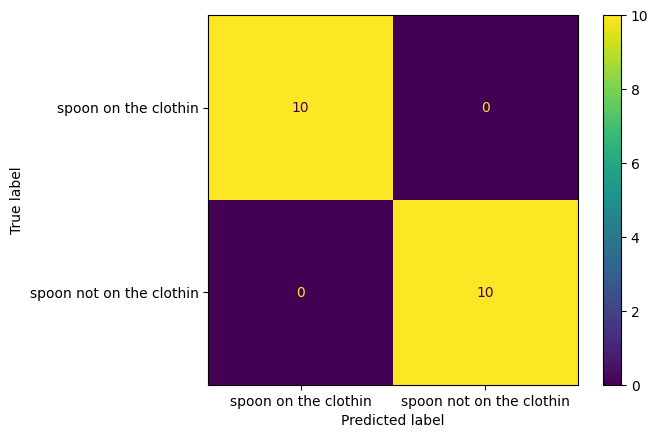

In [42]:
spoon_on_the_plate = ["spoon on the clothin"]*10
spoon_not_on_the_plate = ["spoon not on the clothin"]*10
targets = spoon_on_the_plate + spoon_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in spoon_on_table_clothin_files.items():
    preds_on_the_plate.append("spoon on the clothin" if item["last_iter_QA"]["Is the green/yellow object on the blue object in this image? Yes/No."].lower().find("yes") != -1 else "spoon not on the clothin")
    preds_not_on_the_plate.append("spoon on the clothin" if item["first_iter_QA"]["Is the green/yellow object on the blue object in this image? Yes/No."].lower().find("yes") != -1 else "spoon not on the clothin")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["spoon on the clothin", "spoon not on the clothin"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoon on the clothin", "spoon not on the clothin"])

disp.plot()

##### Как видно из данных, гипотеза про цветовое распознование объектов имеет место быть

## SFT Train

### Сначала как и прежде соберём датасет

In [10]:
def convert_ndarrays(obj):
        if isinstance(obj, dict):
            return {k: convert_ndarrays(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_ndarrays(v) for v in obj]
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj

def build_jsonl_from_first_and_last_SFT(data, questions, answer_key, output_file=None):
    os.makedirs("./images", exist_ok=True)

    assert output_file != None, "Set the output filename!"
    counter = 0

    with open(output_file, "w", encoding="utf-8") as f:
        for question in questions:
            for _, item in data.items():

                img_first = f"./images/first_iter_{question}_{counter}.png"
                item["first_iter"]["image"].save(img_first)
                img_first = os.path.relpath(img_first)

                img_last = f"./images/last_iter_{question}_{counter}.png"
                item["last_iter"]["image"].save(img_last)
                img_last = os.path.relpath(img_last)

                sample = {
                    "image": img_first,  
                    "question": question, 
                    "answer": "yes" if item["first_iter"]["data"][answer_key] else "no",
                    "data": convert_ndarrays(item["first_iter"]["data"]),
                }
                f.write(json.dumps(sample, ensure_ascii=False) + "\n")
                sample = {
                    "image": img_last,  
                    "question": question,
                    "answer": "yes" if item["last_iter"]["data"][answer_key] else "no",
                    "data": convert_ndarrays(item["last_iter"]["data"]),
                }
                f.write(json.dumps(sample, ensure_ascii=False) + "\n")
                counter+=1

    
    print(f"Saved {counter*2} samples to {output_file}")
    return output_file

def build_jsonl_from_general_data(data, output_file=None):
    os.makedirs(f"./dataset_images", exist_ok=True)

    assert output_file != None, "Set the output filename!"
    counter = 0

    with open(output_file, "w", encoding="utf-8") as f:
        for filename, item in data.items():
            # print(filename.split(".npz")[0])
            dir_name = f"./dataset_images/{filename.split(".npz")[0]}"
            os.makedirs(dir_name, exist_ok=True)
            for i in range(len(item)):

                img = f"{dir_name}/{i}_frame_image.png"
                item[f"{i}_frame"]["image"].save(img)
                img = os.path.relpath(img)

                sample = {
                    "image": img,  
                    "data": convert_ndarrays(item[f"{i}_frame"]["data"]), 
                    # "answer": "yes" if item["first_iter"]["data"][answer_key] else "no"
                }
                f.write(json.dumps(sample, ensure_ascii=False) + "\n")
            
                counter+=1
    
    print(f"Saved {counter} samples to {output_file}")
    return output_file

In [11]:
questions = [
    "Is the carrot on the plate?",
    "Is the carrot placed on the plate?",
    "Has the carrot been put on the plate?",
]
qa_dataset_file = build_jsonl_from_first_and_last_SFT(carrot_on_plate_files, questions, "src_on_target", "carrot_on_the_plate_dataset.jsonl")

Saved 120 samples to carrot_on_the_plate_dataset.jsonl


In [9]:
build_jsonl_from_general_data(carrot_on_plate_file_one_episode, output_file="carrot_on_plate_one_episode.jsonl")

Saved 34 samples to carrot_on_plate_one_episode.jsonl


'carrot_on_plate_one_episode.jsonl'

In [13]:
df = pd.read_json("carrot_on_the_plate_dataset.jsonl", lines=True)

df.to_json("train.jsonl", orient="records", lines=True)

dataset = load_dataset(
    "json",
    data_files={"train": "train.jsonl"}
)

Generating train split: 120 examples [00:00, 19804.69 examples/s]


### Теперь зададим обучающие параметры

In [ ]:
try:
    del model
    print("delete model")
except:
    pass
try:
    del processor  
    print("delete processor")
except:
    pass

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

lora_config = LoraConfig(
    r=16,             
    lora_alpha=16,    
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],  
    lora_dropout=0.1,
    use_dora = True,
    init_lora_weights="gaussian",
)

model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager", 
).to(DEVICE)

model.add_adapter(lora_config)
model.enable_adapters()
# model = prepare_model_for_kbit_training(model)
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

In [ ]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
  texts = []
  images = []
  for example in examples:
      image = Image.open(example["image"]).convert("RGB")
      question = example["question"]
      answer = example["answer"]
      messages = [
          {
              "role": "user",
              "content": [
                #   {"type": "text", "text": "Answer briefly."},
                  {"type": "image"},
                  {"type": "text", "text": question}
              ]
          },
          {
              "role": "assistant",
              "content": [
                  {"type": "text", "text": answer}
              ]
          }
      ]
      text = processor.apply_chat_template(messages, add_generation_prompt=False)
      texts.append(text.strip())
      images.append([image])

  batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
  labels = batch["input_ids"].clone()
  labels[labels == processor.tokenizer.pad_token_id] = -100
  labels[labels == image_token_id] = -100
  batch["labels"] = labels

  return batch

In [ ]:
model_name = model_id.split("/")[-1]

training_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=15,
    save_strategy="steps",
    save_steps=250,
    save_total_limit=1,
    optim="paged_adamw_8bit", # for 8-bit, keep this, else adamw_hf
    bf16=True, # underlying precision for 8bit
    output_dir=f"./{model_name}-carrots-and-plates",
    remove_unused_columns=False,
    gradient_checkpointing=True,

    report_to=[],
    push_to_hub=False,
    hub_model_id=None
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=processor,
)

trainer.train()

### Проверяем полученную модель

Создадим тестовые данные:

```

conda activate rlvla_env
cd RL4VLA/ManiSkill
cuda=0

CUDA_VISIBLE_DEVICES=$cuda \
python -m mani_skill.examples.motionplanning.widowx.collect_simpler \
  -e "PutOnPlateInScene25Single-v1" \
  --save_video --save_data --num_procs 1 --num_traj 20 --seed=1

```

In [13]:
carrot_on_plate_files_test = load_data_from_npz("./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/20/data")

In [14]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

fit_model_id = "MrAnton/smolvlm-sft-carrots" 

base_model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(base_model_id)

model = AutoModelForVision2Seq.from_pretrained(
    fit_model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager"
).to(DEVICE)


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 9147.88it/s]
/home/anton/miniconda3/lib/python3.13/site-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


#### Question - Carrot on plate

In [17]:
question = ["Is the carrot on the plate?"]

collect_answers(carrot_on_plate_files_test, question, model=model, processor=processor)

0it [00:00, ?it/s]

collecting data from 20/20 file: success_proc_0_numid_5_epsid_5.npz: : 20it [03:28, 10.45s/it]  


['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate']


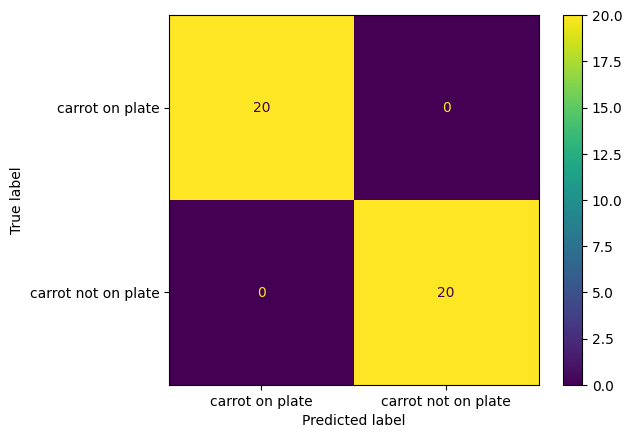

In [19]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files_test.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
    
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

In [20]:
question = ["Is the orange object on the yellow object in this image?"]

collect_answers(carrot_on_plate_files_test, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_5_epsid_5.npz: : 20it [03:35, 10.80s/it]  


['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate']


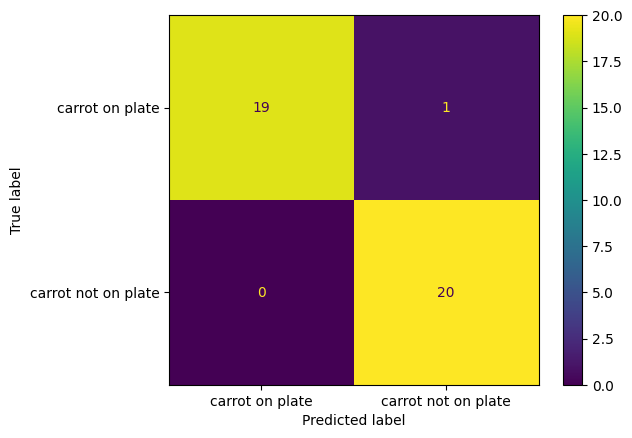

: 

In [ ]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files_test.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the orange object on the yellow object in this image?"].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the orange object on the yellow object in this image?"].lower().find("yes") != -1 else "carrot not on plate")

print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

Это говорит о том, что дообучение никак не повлияло на "Цветовое восприятие" объектов, даже улучшило его

In [25]:
question = ["Is the carrot on the plate?"]

collect_answers_general(carrot_on_plate_file_one_episode, question, model=model, processor=processor)

collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [01:50, 110.69s/it]


['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot no

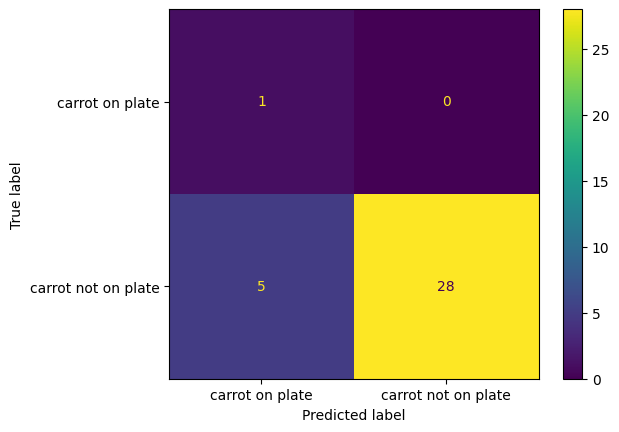

In [26]:
targets = []
preds = []


for _, item in carrot_on_plate_file_one_episode.items():
    for i in range(len(item)):
        preds.append("carrot on plate" if item[f"{i}_frame"]["QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
        targets.append("carrot on plate" if item[f"{i}_frame"]["data"]["src_on_target"] else "carrot not on plate")
print(preds, targets)

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

##### На самом деле модель отработала очень хорошо, просто в данном случае как раз последние 6 картинок являют собой пересечение тарелки и морковки, поэтому модель думает, что морковь уже лежит на тарелке

In [28]:
for pred in preds:
    print(pred)

carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot on plate
carrot on plate
carrot on plate
carrot on plate
carrot on plate


Text(0.5, 1.0, 'yes')

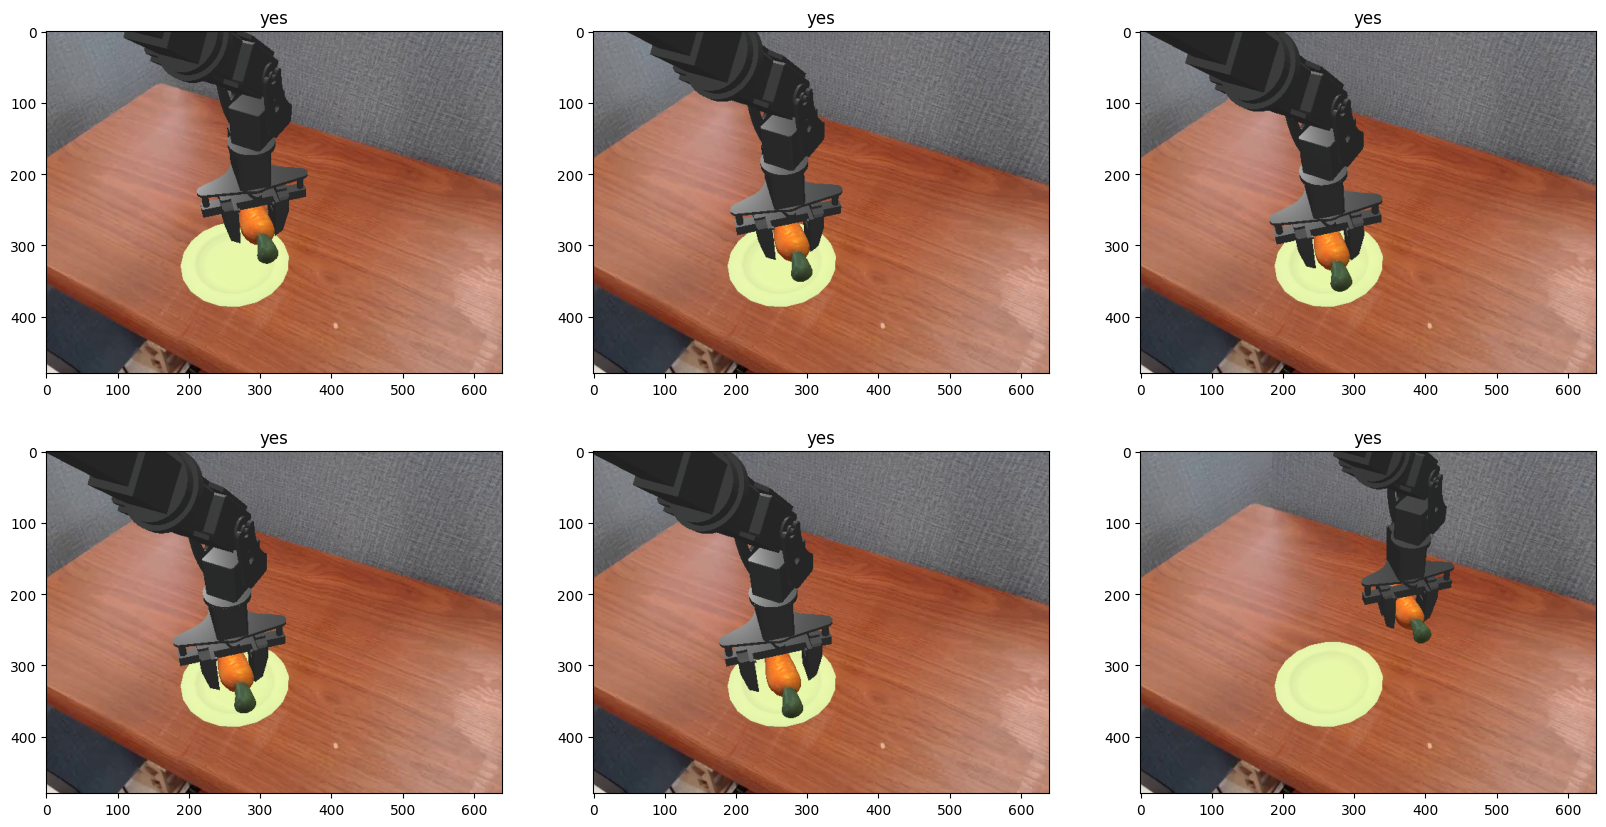

In [34]:
n = 33
fig = plt.figure(figsize=(20, 10))
for i in range(5):
    sub = fig.add_subplot(2, 3, i+1)
    sub.imshow(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{29+i}_frame"]["image"])
    sub.set_title(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{29+i}_frame"]["QA"]["Is the carrot on the plate?"])

sub = fig.add_subplot(2, 3, 6)
sub.imshow(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{18}_frame"]["image"])
sub.set_title(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{18}_frame"]["QA"]["Is the carrot on the plate?"])

In [ ]:
question = ["Is there an object that can be eaten?"]

collect_answers_general(carrot_on_plate_file_one_episode, question, model=model, processor=processor)

collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [01:52, 112.09s/it]


In [6]:
for _, item in carrot_on_plate_file_one_episode.items():
    for i in range(len(item)):
        print(item[f"{i}_frame"]["QA"]["Is there an object that can be eaten?"])

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [7]:
question = ["Is there an object that can be eaten? If yes, what is it?"]

collect_answers_general(carrot_on_plate_file_one_episode, question, model=model, processor=processor)

collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [01:55, 115.34s/it]


In [8]:
for _, item in carrot_on_plate_file_one_episode.items():
    for i in range(len(item)):
        print(item[f"{i}_frame"]["QA"]["Is there an object that can be eaten? If yes, what is it?"])

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


Так как все данные для SFT содержали в себе только один токен - результат предсказуем. Думаю если сделать больше выходных токенов - она будет говорить, что на каждом изображении морковь

Это доказывает, что модель теперь более - менее понимает, что такое морковь, и когда она на тарелке.

### Question - spoon on clothin

In [24]:
question = ["Is the spoon on the clothin?"]

collect_answers(spoon_on_table_clothin_files, question, model=model, processor=processor)

collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [01:35,  9.55s/it]


['spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


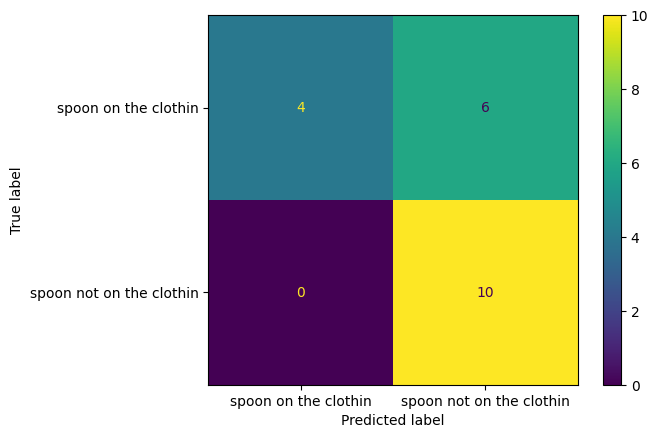

In [25]:
spoon_on_the_plate = ["spoon on the clothin"]*10
spoon_not_on_the_plate = ["spoon not on the clothin"]*10
targets = spoon_on_the_plate + spoon_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in spoon_on_table_clothin_files.items():
    preds_on_the_plate.append("spoon on the clothin" if item["last_iter_QA"]["Is the spoon on the clothin?"].lower().find("yes") != -1 else "spoon not on the clothin")
    preds_not_on_the_plate.append("spoon on the clothin" if item["first_iter_QA"]["Is the spoon on the clothin?"].lower().find("yes") != -1 else "spoon not on the clothin")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["spoon on the clothin", "spoon not on the clothin"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoon on the clothin", "spoon not on the clothin"])

disp.plot()

In [26]:
preds

['spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin']

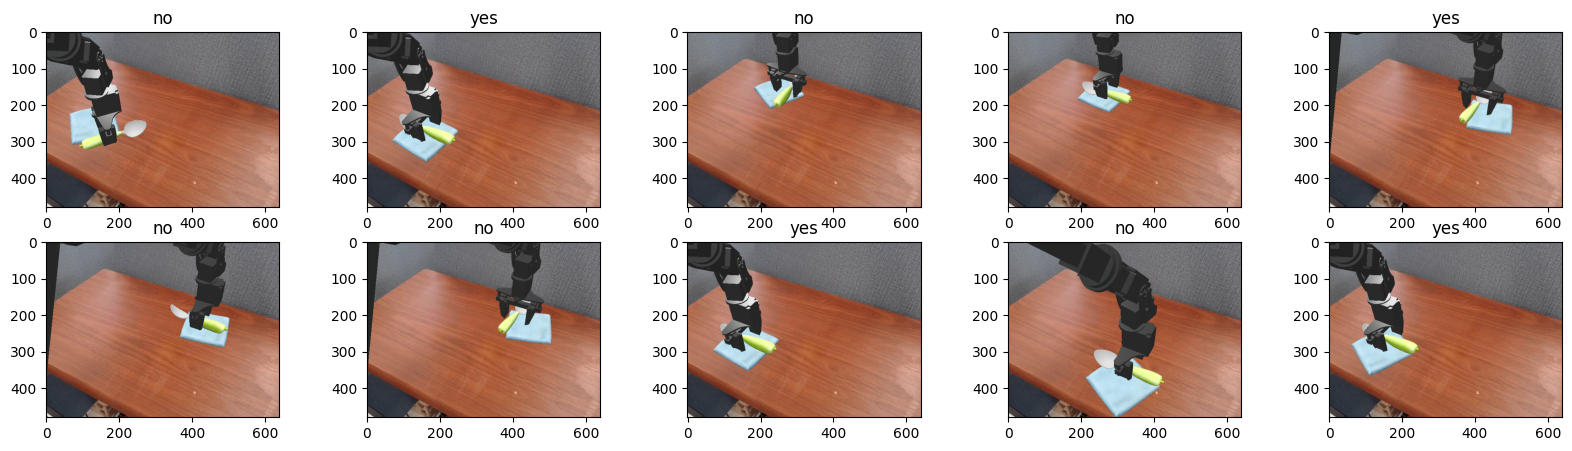

In [31]:
fig = plt.figure(figsize=(20, 5))
for i, (_, item) in enumerate(spoon_on_table_clothin_files.items()):
    sub = fig.add_subplot(2, 5, i+1)
    sub.imshow(item["last_iter"]["image"])
    sub.set_title(item["last_iter_QA"]["Is the spoon on the clothin?"])

После этого проверить способность дообученной модели ещё на "Кубики сейчас друг на друге?" и "Зелёный объект сейчас на жёлтом объекте?"

## GRPO Train

### Над датасетом для GRPO опять придётся немного "Подшаманить"

In [28]:
import datasets

SYSTEM_PROMPT = (
    "Answer strictly in the format: "
    "yes/no, <number> "
    "Example: yes, 0.3 "
    "Example: no, 0 "
)

def make_conversation(example):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": SYSTEM_PROMPT},
                {"type": "image"},
                {"type": "text", "text": example["question"]},
            ],
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    return {
        "prompt": prompt,
        "image": example["image"],
        "labels": example["answer"], 
        "dist_between_answer": example["data"]["carrot_plate_dist"] #DESIGN
    }

dataset_grpo = dataset["train"].cast_column("image", datasets.Image(decode=True))
dataset_grpo = dataset_grpo.map(make_conversation)
dataset_grpo = dataset_grpo.remove_columns(["question", "answer", "data"])

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map: 100%|██████████| 120/120 [00:01<00:00, 82.36 examples/s]


In [29]:
print(dataset_grpo[0]["prompt"])

<|im_start|>User: Answer strictly in the format: yes/no, <number> Example: yes, 0.3 Example: no, 0 <image>Is the carrot on the plate?<end_of_utterance>
Assistant:


In [ ]:
del model, trainer
# Clear caches
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id, use_fast=True, padding_side='left')

lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,             
    lora_alpha=8,    
    target_modules=['q_proj', 'v_proj'],  
    lora_dropout=0.1,
)
lora_config.inference_mode = False

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    _attn_implementation="eager", 
).to(DEVICE)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 11831.61it/s]


trainable params: 755,712 || all params: 257,240,640 || trainable%: 0.2938


In [ ]:
import re

def crt_on_plt_reward_function(completions, **kwargs):
    rewards = []
    labels = kwargs["labels"]  # ground truth answers

    for comp, label in zip(completions, labels):
        row_rewards = 0.0
        comp_lower = comp.lower()
        if "yes" in comp_lower and label == "yes":
            row_rewards = 1.0
        elif "no" in comp_lower and label == "no":
            row_rewards = 1.0
        
        rewards.append(row_rewards)

    print("COMP LIST: ", completions)
    print("ROW REWARDS: ", rewards)
    print("LABELS LIST: ", labels)
    return rewards

def dist_between_plt_and_carrot(completions, **kwargs):
    gt_list = kwargs["dist_between_answer"]
    rewards = []

    for cand, gt in zip(completions, gt_list):
        match = re.search(r"[+]?\d*\.?\d+", str(cand))
        if match:
            pred_val = float(match.group(0))
            rewards.append(-abs(pred_val - gt))
        else:
            rewards.append(-5.0)

In [32]:
import re

completions = ["no, 0.1", "no, 0.6", "yes, 0.0"]

gt_list = [0.4, 0.4, 0.4]
rewards = []

for cand, gt in zip(completions, gt_list):
    match = re.search(r"[+]?\d*\.?\d+", str(cand))
    if match:
        pred_val = float(match.group(0))
        print(pred_val)
        rewards.append(-abs(pred_val - gt))
    else:
        rewards.append(-5.0)
print(rewards)


0.1
0.6
0.0
[-0.30000000000000004, -0.19999999999999996, -0.4]


In [ ]:
cfg = GRPOConfig(
    output_dir=f"./{model_id}_grpo_simpler_task",
    learning_rate=1e-5,
    remove_unused_columns=False,  # to access the solution column in accuracy_reward
    num_train_epochs=1,
    bf16=True,
    # Parameters that control the data preprocessing
    per_device_train_batch_size=2,
    max_completion_length=1,  # default: 256
    num_generations=2,  # default: 8
    max_prompt_length=2048,
    # gradient_accumulation_steps=2,
    # Parameters related to reporting and saving
    # report_to=["tensorboard"],
    # logging_steps=10,
    # push_to_hub=True,
    # save_strategy="steps",
    # save_steps=10,

    logging_steps=15,
    save_strategy="epoch",
    # save_steps=250,
    save_total_limit=1,

    report_to=[],
    push_to_hub=False,
    hub_model_id=None
)

trainer = GRPOTrainer(
    model=model,
    processing_class=processor,
    reward_funcs=[crt_on_plt_reward_function],
    args=cfg,
    train_dataset=dataset_grpo,
)

trainer.train()

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# fine-tuned checkpoint (weights + config.json)
fit_model_id = "./HuggingFaceTB/SmolVLM-256M-Instruct_GRPO_CrtOnPlt/checkpoint-84" #Также сделать загрузку из HF

# load processor from the *original* pretrained model
base_model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(base_model_id)

# load the fine-tuned weights
model = AutoModelForVision2Seq.from_pretrained(
    fit_model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager"
).to(DEVICE)

## Другие эксперименты для проверок разных гипотез

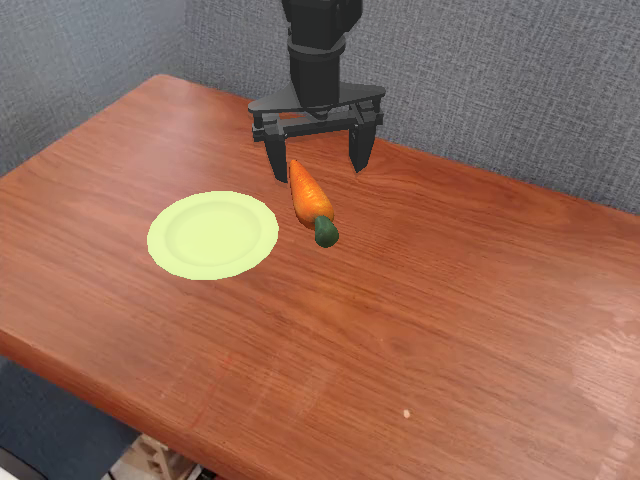

In [47]:
from PIL import Image

# Load images and convert to RGBA
img1 = images_for_shadowing[10].convert("RGBA")
img2 = images_for_shadowing[9].convert("RGBA")
img3 = images_for_shadowing[8].convert("RGBA")

# Blend gradually
blend1 = Image.blend(img1, img2, alpha=0.7)  # second image faint
final = Image.blend(blend1, img3, alpha=0.5) # third image even fainter

final


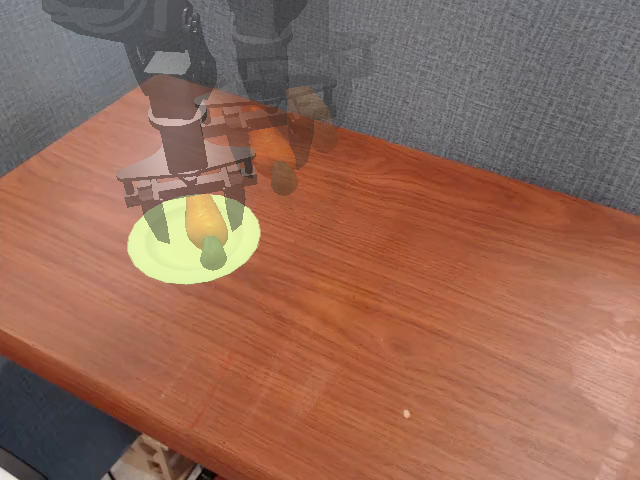

In [86]:
from PIL import Image
import numpy as np

def create_trail(frames, alphas=None):
    """
    Create a motion trail effect by blending multiple PIL RGB frames.
    
    frames: list of PIL.Image.Image objects (all same size, RGB).
    alphas: list of weights (same length as frames) — if None, use fading weights.
    
    Returns: PIL.Image.Image with trail effect.
    """
    n = len(frames)
    if alphas is None:
        # Decreasing weights (strongest for most recent frame)
        alphas = np.linspace(0.8, 0.1, n)  
    alphas = np.array(alphas) / np.sum(alphas)  # normalize
    
    # Convert frames to numpy arrays
    arrays = [np.asarray(f).astype(np.float32) for f in frames]
    
    # Weighted sum
    result = np.zeros_like(arrays[0])
    for arr, w in zip(arrays, alphas):
        result += arr * w
    
    result = np.clip(result, 0, 255).astype(np.uint8)
    return Image.fromarray(result)

ifs = images_for_shadowing[::-4]
trail_img = create_trail(ifs[0:4])
trail_img


In [ ]:
# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "Can you describe the carrot path?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[images_for_shadowing[0], images_for_shadowing[-1]], return_tensors="pt")
inputs = inputs.to(DEVICE)

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])

User:







Can you describe the carrot path?
Assistant: The carrot is on the carrot path.


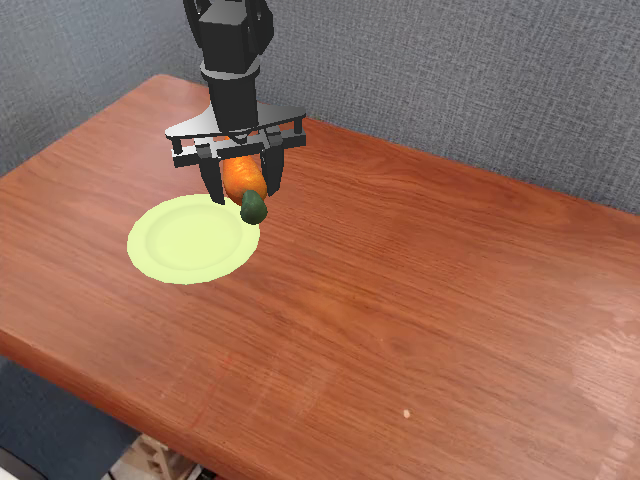

In [95]:
images_for_shadowing[-4]

In [ ]:
# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "Can you describe the carrot path?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[images_for_shadowing[0], images_for_shadowing[-1]], return_tensors="pt")
inputs = inputs.to(DEVICE)

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])